<a href="https://colab.research.google.com/github/akshatshaw/Stock-sentiment-analysis/blob/main/word_embbedding_sentiment_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
!pip install -q yfinance

In [4]:
import yfinance as yf
import gensim

In [9]:
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\finance stock\web scrap data of amazon\amazon_stock_news.csv").drop(columns=['time','ticker','sentiment','source'])

In [11]:
df

,headline,date
0,9 Gun and Ammo Stocks to Buy If Biden Wins,2020-10-14
1,Investors Should Wait to Buy the Pullback in S...,2020-10-14
2,Peacock tops among streamers in Q3 for new sub...,2020-10-14
3,Amazon's EU antitrust probe could become two i...,2020-10-14
4,"Snowflake Stock Is No Bargain, but It May Not ...",2020-10-14
...,...,...
9945,3 Tech Stocks That Will Rise Thanks to Google’...,2024-06-19
9946,Blue Chip Lovers: 3 Safe Stocks to Double Your...,2024-06-19
9947,Amazon Fined $5.9 Mln By California For Labor ...,2024-06-19
9948,3 Stocks You Don’t Want to Be Caught Holding W...,2024-06-19


In [13]:
df = df.groupby('date')['headline'].agg(' '.join).reset_index()
df['Date']= pd.to_datetime(df['date'])
df.drop(columns=['date'], inplace = True)

In [15]:
def process(data):
    data['P/L'] = data["Close"]-data['Open']
    data.drop(columns=['Volume','Adj Close'], inplace = True)
    return data

def pull_out(stock, data):
    price = pd.DataFrame(yf.download(stock, period="max"))
    # data = data[data.index>= '2023-12-31']
    price.reset_index(inplace = True)
    merged_df = pd.merge(data, price, on='Date', how='outer').dropna()
    return (merged_df)

In [17]:
data = process(pull_out("AMZN", df))
#  = data['news_articles'].str.lower()
data['text'] = data.headline.apply(gensim.utils.simple_preprocess)
data['target'] =data['P/L'].apply(lambda x: 1 if x > 0 else 0)
news = data.copy()
data.to_csv("amazon.csv", index= False)
news

[*********************100%%**********************]  1 of 1 completed


,headline,Date,Open,High,Low,Close,P/L,text,target
0,9 Gun and Ammo Stocks to Buy If Biden Wins Inv...,2020-10-14,172.350006,173.244003,167.000000,168.185501,-4.164505,"[gun, and, ammo, stocks, to, buy, if, biden, w...",0
1,Pricey Plug Power Stock Could Keep Moving High...,2020-10-15,164.600494,167.794006,164.000000,166.932495,2.332001,"[pricey, plug, power, stock, could, keep, movi...",1
2,Get Ready To Bull Trade Novavax Stock For A Se...,2020-10-16,168.161499,169.983002,158.000000,163.635498,-4.526001,"[get, ready, to, bull, trade, novavax, stock, ...",0
3,4 AI Stocks That Will Surge in 2021 as Artific...,2020-10-19,164.980499,166.449997,159.636993,160.360504,-4.619995,"[ai, stocks, that, will, surge, in, as, artifi...",0
4,"Microsoft, Elon Musk's SpaceX partner to take ...",2020-10-20,161.113998,163.300003,159.600494,160.850494,-0.263504,"[microsoft, elon, musk, spacex, partner, to, t...",0
...,...,...,...,...,...,...,...,...,...
1264,Amazon Adds $1.4 Bln To Housing Equity Fund A...,2024-06-12,188.020004,188.350006,185.429993,186.889999,-1.130005,"[amazon, adds, bln, to, housing, equity, fund,...",0
1265,UBS Keeps Their Buy Rating on Amazon (AMZN) AM...,2024-06-13,186.089996,187.669998,182.669998,183.830002,-2.259995,"[ubs, keeps, their, buy, rating, on, amazon, a...",0
1266,The 3 Best Mutual Funds to Buy in June 2024 AI...,2024-06-14,183.080002,183.720001,182.229996,183.660004,0.580002,"[the, best, mutual, funds, to, buy, in, june, ...",1
1268,3 Reasons to Buy Amazon Stock Now 3 Stocks to ...,2024-06-17,182.520004,185.000000,181.220001,184.059998,1.539993,"[reasons, to, buy, amazon, stock, now, stocks,...",1


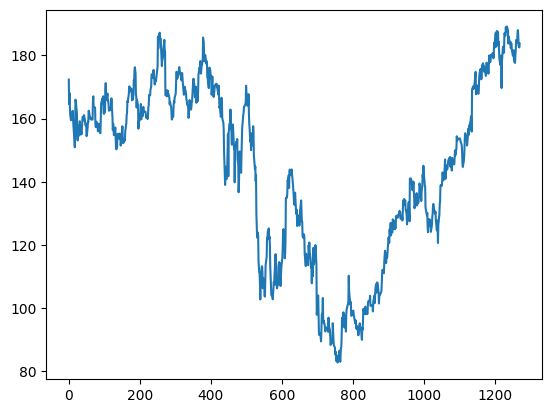

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(data['Open'])

In [21]:
import gensim.downloader

glove_vectors = gensim.downloader.load('word2vec-google-news-300')


In [23]:
def get_average_word2vec(tokens, model):
    valid_tokens = [token for token in tokens if token in model]
    if not valid_tokens:
        return np.zeros(model.vector_size)
    vectors = [model[token] for token in valid_tokens]
    return np.mean(vectors, axis=0)

# Apply the function to the 'tokens' column to get the embeddings
news['embedding'] = news['text'].apply(lambda x: get_average_word2vec(x, glove_vectors))

In [25]:
# Convert embeddings to separate columns
embedding_df = pd.DataFrame(news['embedding'].to_list(), index=news.index)
embedding_df.columns = [f'embedding_{i}' for i in range(embedding_df.shape[1])]

# Concatenate the embeddings with the original DataFrame
news = pd.concat([news, embedding_df], axis=1).drop(columns=['embedding'])

In [27]:
 news.to_csv('final_amazon.csv',index = False)

news = pd.read_csv('final_amazon.csv')

In [73]:
news.head(5)

,headline,Date,Open,High,Low,Close,P/L,text,target,embedding_0,...,embedding_290,embedding_291,embedding_292,embedding_293,embedding_294,embedding_295,embedding_296,embedding_297,embedding_298,embedding_299
0,9 Gun and Ammo Stocks to Buy If Biden Wins Inv...,2020-10-14,172.350006,173.244003,167.000000,168.185501,-4.164505,"['gun', 'and', 'ammo', 'stocks', 'to', 'buy', ...",0,0.018257,...,-0.012205,-0.016614,-0.087342,0.039073,0.020911,-0.001430,-0.011593,-0.028254,0.028940,-0.000732
1,Pricey Plug Power Stock Could Keep Moving High...,2020-10-15,164.600494,167.794006,164.000000,166.932495,2.332001,"['pricey', 'plug', 'power', 'stock', 'could', ...",1,0.027995,...,-0.044200,0.017830,-0.131711,0.025381,0.019154,-0.011258,-0.007423,-0.021859,0.032214,-0.031694
2,Get Ready To Bull Trade Novavax Stock For A Se...,2020-10-16,168.161499,169.983002,158.000000,163.635498,-4.526001,"['get', 'ready', 'to', 'bull', 'trade', 'novav...",0,0.003831,...,-0.027858,0.006637,-0.118973,0.052874,0.028500,-0.002570,-0.000220,-0.038383,0.019276,0.009916
3,4 AI Stocks That Will Surge in 2021 as Artific...,2020-10-19,164.980499,166.449997,159.636993,160.360504,-4.619995,"['ai', 'stocks', 'that', 'will', 'surge', 'in'...",0,0.029333,...,-0.050957,0.002338,-0.096853,0.008061,0.020645,0.007649,-0.002116,-0.019494,0.036947,-0.008995
4,"Microsoft, Elon Musk's SpaceX partner to take ...",2020-10-20,161.113998,163.300003,159.600494,160.850494,-0.263504,"['microsoft', 'elon', 'musk', 'spacex', 'partn...",0,0.042520,...,-0.014982,0.020504,-0.069169,0.060528,0.026375,-0.041059,-0.018079,-0.007671,0.025579,-0.002879


In [75]:
X = news.drop(columns=['Date','Close','headline','P/L','target', 'text','High','Low','Open'])
y=news['target']

In [83]:
X

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_290,embedding_291,embedding_292,embedding_293,embedding_294,embedding_295,embedding_296,embedding_297,embedding_298,embedding_299
0,0.018257,0.017218,0.016975,0.078306,-0.044074,-0.049691,0.033837,-0.089192,0.108322,0.094579,...,-0.012205,-0.016614,-0.087342,0.039073,0.020911,-0.001430,-0.011593,-0.028254,0.028940,-0.000732
1,0.027995,0.045935,-0.016781,0.089802,-0.028231,-0.071797,0.028998,-0.071306,0.118645,0.110883,...,-0.044200,0.017830,-0.131711,0.025381,0.019154,-0.011258,-0.007423,-0.021859,0.032214,-0.031694
2,0.003831,0.022622,-0.010191,0.086157,-0.022854,-0.060939,0.012083,-0.062693,0.117668,0.074956,...,-0.027858,0.006637,-0.118973,0.052874,0.028500,-0.002570,-0.000220,-0.038383,0.019276,0.009916
3,0.029333,0.053927,-0.002389,0.079001,-0.045331,-0.030931,0.011771,-0.073058,0.084637,0.095615,...,-0.050957,0.002338,-0.096853,0.008061,0.020645,0.007649,-0.002116,-0.019494,0.036947,-0.008995
4,0.042520,0.015240,0.022673,0.069958,-0.008777,-0.031498,0.004617,-0.087203,0.109480,0.069113,...,-0.014982,0.020504,-0.069169,0.060528,0.026375,-0.041059,-0.018079,-0.007671,0.025579,-0.002879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,0.031138,0.016384,-0.001701,0.073395,-0.054089,-0.058582,0.010872,-0.114326,0.120426,0.079303,...,-0.037602,0.020710,-0.079870,-0.004257,0.021692,-0.013840,0.004544,-0.007000,0.014068,-0.016527
919,0.021426,0.063866,0.022876,0.093050,-0.038630,-0.051051,0.018406,-0.113123,0.106491,0.088599,...,-0.040076,-0.001450,-0.070500,-0.000330,0.029491,-0.056024,0.005863,-0.006550,0.012611,0.004476
920,0.033144,0.035868,0.026157,0.086651,-0.049262,-0.059729,0.020454,-0.110536,0.094236,0.091096,...,-0.036454,0.006819,-0.103123,0.033077,0.018489,-0.034109,-0.024330,-0.020220,0.010987,-0.010645
921,0.030197,0.011652,0.009094,0.083588,-0.060881,-0.044209,0.011326,-0.107479,0.113590,0.124619,...,-0.032546,0.041927,-0.090031,0.016909,0.044724,-0.020772,0.004407,-0.021304,0.043283,-0.022489


In [85]:
y

0      0
1      1
2      0
3      0
4      0
      ..
918    0
919    0
920    1
921    1
922    0
Name: target, Length: 923, dtype: int64

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range = (1,4),max_features= 10000)

In [65]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2,random_state=2)

In [95]:
X_test

,Open,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_290,embedding_291,embedding_292,embedding_293,embedding_294,embedding_295,embedding_296,embedding_297,embedding_298,embedding_299
305,169.699997,0.014752,0.023821,0.021215,0.077832,-0.049075,-0.030683,0.025452,-0.074349,0.073828,...,-0.045305,0.007195,-0.089203,0.003181,-0.016374,-0.014862,0.001324,-0.015753,0.036648,-0.002960
830,169.389999,0.014544,0.004248,0.014741,0.105433,-0.031950,-0.073507,0.019294,-0.102601,0.122293,...,-0.018484,0.051931,-0.130343,0.027845,-0.010132,-0.002662,-0.004658,0.008060,0.016145,-0.002577
571,92.559998,0.029402,-0.005019,-0.011017,0.091714,-0.053059,-0.025013,0.004276,-0.067398,0.112088,...,-0.028521,0.036147,-0.089500,0.033569,0.052438,0.004251,0.016421,-0.007146,0.034537,0.006790
231,172.126007,0.024591,0.005355,-0.008085,0.106009,-0.011432,-0.071869,0.029876,-0.084498,0.104022,...,-0.058066,0.036562,-0.110196,0.017577,0.015318,-0.024550,0.008457,0.006950,0.040150,-0.018486
811,148.330002,0.032837,-0.007606,-0.014619,0.072878,-0.043185,-0.063310,-0.003269,-0.104609,0.101674,...,-0.056068,0.029078,-0.117619,0.001784,-0.000048,-0.010550,0.009682,-0.026226,0.006681,-0.031352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,124.970001,0.016472,0.017351,0.010171,0.112047,-0.021512,-0.042476,0.014575,-0.066828,0.107653,...,-0.008232,0.045719,-0.130795,0.024986,0.064193,-0.044357,0.002014,-0.011196,-0.014491,-0.011341
595,93.870003,0.007850,0.015949,0.040212,0.072238,-0.042708,-0.090786,-0.007522,-0.135153,0.102542,...,-0.034876,-0.011751,-0.099921,-0.013846,0.016417,-0.046997,-0.020142,-0.006224,0.046991,0.014149
701,130.149994,0.006807,0.011401,0.004437,0.062163,-0.049480,-0.071976,-0.007047,-0.100358,0.117022,...,-0.053255,0.039758,-0.108002,-0.001283,0.005539,-0.007517,0.053199,-0.016848,0.012717,-0.042842
272,175.649994,-0.008523,0.010438,0.013470,0.123058,-0.053968,-0.049471,-0.007235,-0.071164,0.110850,...,-0.006276,0.022289,-0.119890,-0.007027,0.012960,-0.023889,0.027933,-0.009506,0.037200,-0.018947


In [67]:
# total = pd.DataFrame(tfidf.fit_transform(data['text']).toarray())
# train = pd.DataFrame(tfidf.fit_transform(X_train['text']).toarray())
# test= pd.DataFrame(tfidf.fit_transform(X_test['text']).toarray())

!pip install xgboost

In [97]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,f1_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier

In [99]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
bnb = BernoulliNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l2')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)
# cat = CatBoostClassifier( silent = True)

In [107]:
clfs = {
    'SVC' : svc,
    #'KN' : knc,
    # 'NB': mnb,
   # 'BNB': bnb,
    # 'cat':cat,
#     'DT': dtc,
    # 'LR': lrc,
    'RF': rfc,
#     'AdaBoost': abc,
#     'BgC': bc,
#     'ETC': etc,
    # 'GBDT':gbdt,
    'xgb':xgb
 }
from sklearn.model_selection import cross_val_score
def train_classifier(clf,X_train,y_train,X_test,y_test,total, y):
    csr_val = cross_val_score(clf, total, y, cv=3,scoring= "f1")
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    recall = recall_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    f1score = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    return recall,precision ,f1score,accuracy, csr_val.mean()

for name,clf in clfs.items():
    recall,precision,f1score,accuracy,csr_val = train_classifier(clf, X_train,y_train,X_test,y_test,X,y)
    print("For ",name)
    print("recall - ",recall)
    print("Precision - ",precision)
    print("f1_score - ",f1score)
    print("accuracy - ",accuracy)
    print("cross_val_f1- ",csr_val)
    print("************************")

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For  SVC
recall -  0.0
Precision -  0.0
f1_score -  0.0
accuracy -  0.43243243243243246
cross_val_f1-  0.5069120501028658
************************
For  RF
recall -  0.3142857142857143
Precision -  0.5
f1_score -  0.38596491228070173
accuracy -  0.43243243243243246
cross_val_f1-  0.4435747114220831
************************
For  xgb
recall -  0.44761904761904764
Precision -  0.5662650602409639
f1_score -  0.5
accuracy -  0.4918918918918919
cross_val_f1-  0.5158770484015549
************************
